In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage import color, data, io
from skimage.color import rgb2lab, lab2rgb
from skimage.feature import Cascade
from skimage.exposure import rescale_intensity as rescale_intensity
from skimage.util import img_as_ubyte
from ipywidgets import interact, widgets

In [2]:
trained_file = data.lbp_frontal_face_cascade_filename()
detector = Cascade(trained_file)

In [3]:
TRUTH = "Images/A01/white-balance-true.jpg"
SOURCE = "Images/A01/white-balance-fluorescent.jpg" # fluorescent, tungsten
source = io.imread(SOURCE)
truth = io.imread(TRUTH)

In [4]:
def show_face_detected(img):
    global detected
    detected = detector.detect_multi_scale(img=rescale_intensity(img,in_range=(100,255)), scale_factor=1.1, step_ratio=1,min_size=(100, 100),max_size=(200, 200))
    #plt.imshow(img)
    img_desc = plt.gca()

    for patch in detected:

        img_desc.add_patch(
            patches.Rectangle(
                (patch['c'], patch['r']),
                patch['width'],
                patch['height'],
                fill=False,
                color='r',
                linewidth=2
            )
        )

    skin_patch = (detected[0]['r'] + detected[0]['height']//2, detected[0]['c'] + detected[0]['width']//2)
    PATCH_RADIUS = 4
    skin_sample = img[skin_patch[0] - PATCH_RADIUS:skin_patch[0]+PATCH_RADIUS,skin_patch[1]-PATCH_RADIUS:skin_patch[1]+PATCH_RADIUS]
    plt.imshow(skin_sample)
    return skin_sample

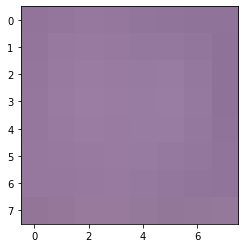

In [5]:
sourceSkin=show_face_detected(source)

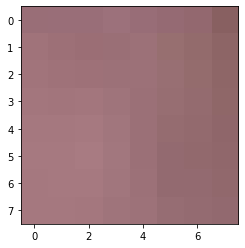

In [6]:
truthSkin=show_face_detected(truth)

In [7]:
#color difference 
def color_difference(img1, img2):
    difference = np.mean(color.deltaE_cie76(img1, img2))
    print("color difference:" + str(difference))

In [8]:
color_difference(source, truth)

color difference:8.305


In [9]:
def show_image_before_after_white_balance(img_01, img_02, img_03,name1,name2,name3):
    %matplotlib inline
 
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 9))
    ax1.imshow(img_01)
    ax2.imshow(img_02)
    ax3.imshow(img_03)
    
    ax1.set_title(name1)
    ax2.set_title(name2)
    ax3.set_title(name3)
    
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()
    
    plt.show()

In [10]:
def show_image_before_after(img_01, img_02, img_03,img_04,name1,name2,name3,name4):
    %matplotlib inline
 
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(16, 9))
    ax1.imshow(img_01)
    ax2.imshow(img_02)
    ax3.imshow(img_03)
    ax4.imshow(img_04)
    ax1.set_title(name1)
    ax2.set_title(name2)
    ax3.set_title(name3)
    ax4.set_title(name4)
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()
    ax4.set_axis_off()
    plt.show()

In [11]:
#skin samples
skinSelect = [[78,79, 37],[141,85, 36],[198, 134, 66],[224, 172, 105],[241, 194, 125],[255, 219, 172],[239, 221, 208]]
skinColor = 6
def selectSkinColor():
    currentskincolor = skinSelect[skinColor-1]
    skinImage = np.array([[currentskincolor,currentskincolor,currentskincolor,currentskincolor],[currentskincolor,currentskincolor,currentskincolor,currentskincolor],[currentskincolor,currentskincolor,currentskincolor,currentskincolor],[currentskincolor,currentskincolor,currentskincolor,currentskincolor]])
    return skinImage


In [12]:
def clip(x,m):
    if x>m:
        return m
    else:
        return x
    

In [13]:
def clip_min(y,n):
    if y<n:
        return n
    else:
        return y

In [14]:
clip_mx = np.vectorize(clip)
clip_min_mx = np.vectorize(clip_min)

In [15]:
#colorCorrect (RGB color space)
def colorCorrect(sourceSample,targetSample):
    
    S_R = np.mean(targetSample [:,:,0])/np.mean(sourceSample [:,:,0]) # scaling of R
    S_G = np.mean(targetSample [:,:,1])/np.mean(sourceSample [:,:,1]) # scaling of G
    S_B = np.mean(targetSample [:,:,2])/np.mean(sourceSample [:,:,2]) # scaling of B
    
    
    R_adjusted = clip_mx(S_R *source[:,:,0], 255).astype('uint8')
    G_adjusted = clip_mx(S_G *source[:,:,1], 255).astype('uint8')
    B_adjusted = clip_mx(S_B *source[:,:,2], 255).astype('uint8')

    adjusted_image = np.dstack((R_adjusted, G_adjusted, B_adjusted))
    
    return adjusted_image
    
    

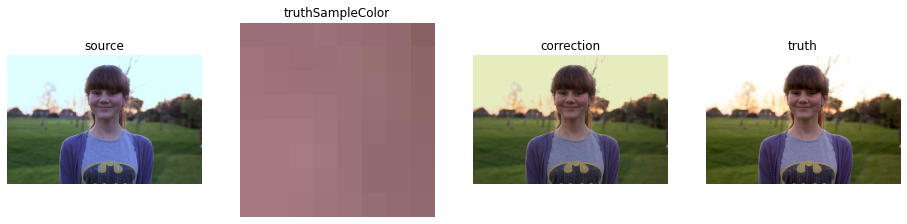

color difference:10.336


In [16]:
show_image_before_after(source,truthSkin, colorCorrect(sourceSkin,truthSkin),truth,  "source","truthSampleColor", "correction","truth")
color_difference(colorCorrect(sourceSkin,truthSkin),truth)

In [17]:
def add(a,b):
    return a+b

In [18]:
add_mx = np.vectorize(add)

In [19]:
#colorCorrect (L*ab color space) only adjust B channel(blue,yellow)
def colorCorrect_lab(sourceSample,targetSample):  
    #convert rgb color to L*ab color
    sourceSample_lab = color.rgb2lab(sourceSample)
    targetSample_lab = color.rgb2lab(targetSample)
    source_lab = color.rgb2lab(source)
    
    
    K_B = np.mean(targetSample_lab [:,:,2])-np.mean(sourceSample_lab [:,:,2]) # scaling of B chanel
    
    
    L_adjusted = source_lab[:,:,0]
    A_adjusted = source_lab[:,:,1]
    B_adjusted = source_lab[:,:,2]+ K_B

    adjusted_lab = np.dstack((L_adjusted, A_adjusted, B_adjusted))
    adjusted_image = img_as_ubyte(lab2rgb(adjusted_lab))
    return adjusted_image

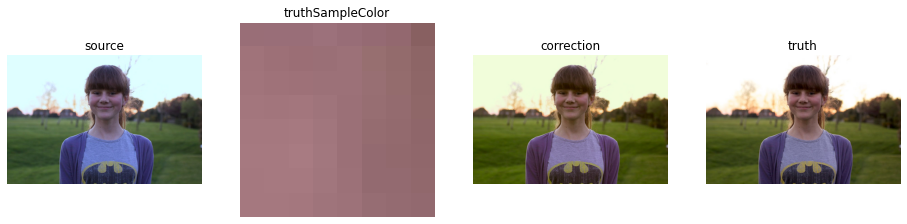

color difference:9.31


In [20]:
show_image_before_after(source,truthSkin, colorCorrect_lab(sourceSkin,truthSkin),truth,  "source","truthSampleColor", "correction","truth")
color_difference(colorCorrect_lab(sourceSkin,truthSkin),truth)

In [21]:
# color correction RGB with selected skin samples
%matplotlib inline
def set_skinColor(target_skin):
    global skinColor
    skinColor = target_skin
    selectSkinColor()

    correctionImage = colorCorrect(sourceSkin,selectSkinColor())    
    show_image_before_after(source,selectSkinColor(), correctionImage,truth,  "source", "selectColor","correction","truth")
    color_difference(correctionImage, truth)
_ = interact(set_skinColor, target_skin = widgets.IntSlider(min = 1, max = len(skinSelect), step = 1, value = skinColor))
   

interactive(children=(IntSlider(value=6, description='target_skin', max=7, min=1), Output()), _dom_classes=('w…

In [22]:
# color correction L*AB with selected skin samples
%matplotlib inline

def set_skinColor1(target_skin):
    global skinColor
    skinColor1 = target_skin
    selectSkinColor()
    
    correction = colorCorrect_lab(sourceSkin, selectSkinColor())
    show_image_before_after(source, selectSkinColor(), correction, truth, "source", "selectColor","correction","truth")
    color_difference(correction, truth)
_ = interact(set_skinColor, target_skin = widgets.IntSlider(min = 1, max = len(skinSelect), step = 1, value = skinColor))
   

interactive(children=(IntSlider(value=6, description='target_skin', max=7, min=1), Output()), _dom_classes=('w…

In [23]:
# only gray word white balance

In [24]:
def awb_GW_image(img):
    clip_mx=np.vectorize(clip)
    
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    alpha=np.mean(g)/np.mean(r)
    beta=np.mean(g)/np.mean(b)
    
    a_r=clip_mx(alpha*r,255).astype("uint8")
    a_g=g.astype("uint8")
    a_b=clip_mx(beta*b,255).astype("uint8")   
    
    return np.dstack((a_r,a_g,a_b)) 

In [25]:
white_balance = awb_GW_image(source)

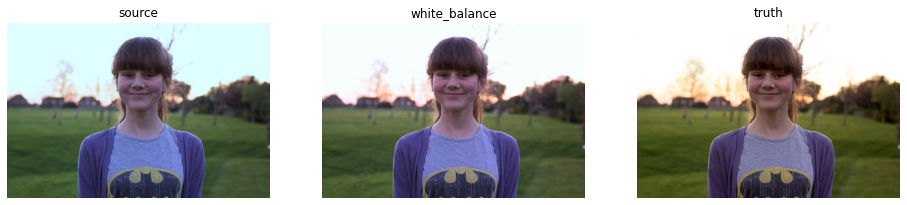

color difference:10.33


In [26]:
show_image_before_after_white_balance(source, white_balance,truth, "source","white_balance","truth")
color_difference(white_balance, truth)

In [27]:
# correction then gray world white balance

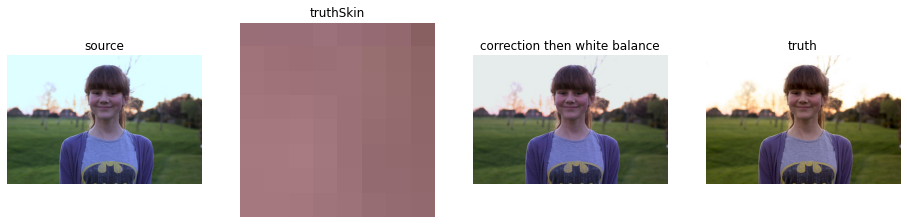

color difference:10.51


In [28]:
blender1_truthSkin = awb_GW_image(colorCorrect(sourceSkin,truthSkin))
show_image_before_after(source,truthSkin, blender1_truthSkin,truth,  "source", "truthSkin","correction then white balance","truth")
color_difference(blender1_truthSkin, truth)

In [29]:
%matplotlib inline

def set_focus(new_focus):
    global skinColor
    skinColor = new_focus
    selectSkinColor()
    blender1 = awb_GW_image(colorCorrect(show_face_detected(source),selectSkinColor()))
    
    
    
    show_image_before_after(source,selectSkinColor(), blender1,truth,  "source", "selectColor","correction then white balance","truth")
    color_difference(blender1, truth)
    
_ = interact(set_focus, new_focus = widgets.IntSlider(min = 1, max = len(skinSelect), step = 1, value = skinColor))

interactive(children=(IntSlider(value=6, description='new_focus', max=7, min=1), Output()), _dom_classes=('wid…

In [30]:
# correction(L*ab) then white balance

In [31]:
cl_wb = awb_GW_image(colorCorrect_lab(sourceSkin,truthSkin))

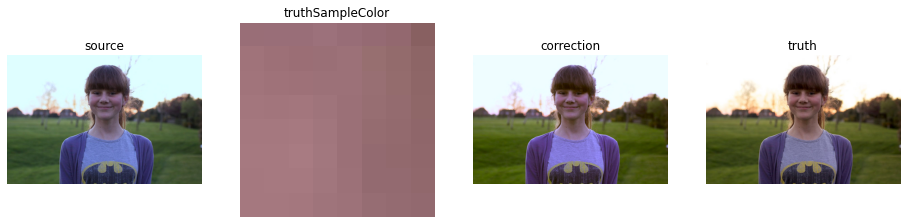

color difference:8.22


In [32]:
show_image_before_after(source,truthSkin, cl_wb,truth,"source","truthSampleColor", "correction","truth")
color_difference(cl_wb,truth)

In [33]:
%matplotlib inline

def set_focus(new_focus):
    global skinColor
    skinColor = new_focus
    selectSkinColor()
    
    awb_GW_image(colorCorrect_lab(sourceSkin, selectSkinColor()))
    show_image_before_after(source,selectSkinColor(),awb_GW_image(colorCorrect_lab(sourceSkin, selectSkinColor())), truth, "source", "selectColor","correction then white balance","truth")
    color_difference(awb_GW_image(colorCorrect_lab(sourceSkin, selectSkinColor())), truth)  
_ = interact(set_focus, new_focus = widgets.IntSlider(min = 1, max = len(skinSelect), step = 1, value = skinColor))

interactive(children=(IntSlider(value=6, description='new_focus', max=7, min=1), Output()), _dom_classes=('wid…

In [34]:
# white balance then correction

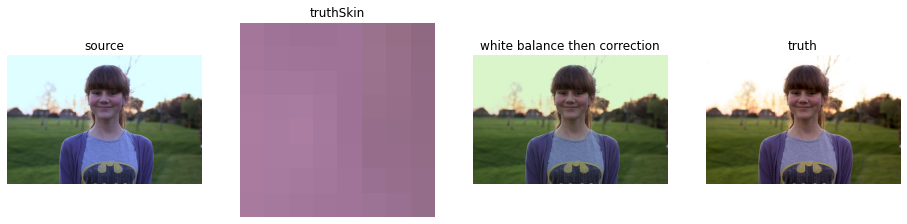

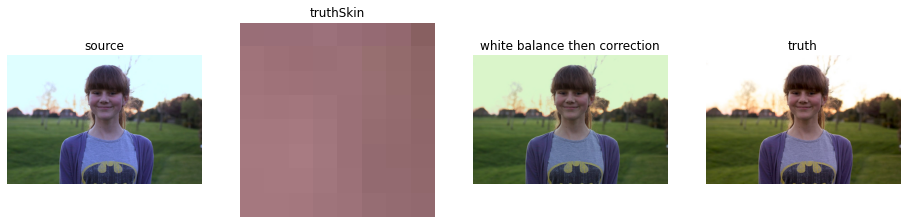

color difference:11.32


In [35]:


white_balance = awb_GW_image(source)
    
blender2_truthSkin = colorCorrect(show_face_detected(white_balance),truthSkin)
    
    
show_image_before_after(source,show_face_detected(white_balance),blender2_truthSkin,truth,  "source", "truthSkin","white balance then correction","truth")    
show_image_before_after(source,truthSkin,blender2_truthSkin,truth,  "source", "truthSkin","white balance then correction","truth")
color_difference(blender2_truthSkin, truth)
    


In [36]:
%matplotlib inline

def set_focus(new_focus):
    global skinColor
    skinColor = new_focus
    white_balance = awb_GW_image(source)
    
    selectSkinColor()
    
    
    blender2 = colorCorrect(show_face_detected(white_balance),selectSkinColor())
    
    
    
    show_image_before_after(source,selectSkinColor(), blender2,truth,  "source", "selectColor","white balance then correction","truth")
    color_difference(blender2, truth)
    
_ = interact(set_focus, new_focus = widgets.IntSlider(min = 1, max = len(skinSelect), step = 1, value = skinColor))

interactive(children=(IntSlider(value=6, description='new_focus', max=7, min=1), Output()), _dom_classes=('wid…

In [37]:
# white balance then correction(L*ab)

In [38]:
wb_c = colorCorrect_lab(awb_GW_image(source), truthSkin)

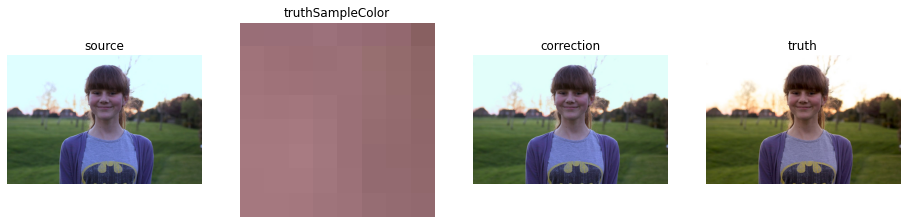

color difference:10.164


In [39]:
show_image_before_after(source,truthSkin, wb_c,truth,  "source","truthSampleColor", "correction","truth")
color_difference(wb_c,truth)

In [40]:
%matplotlib inline

def set_focus(new_focus):
    global skinColor
    skinColor = new_focus
    white_balance = awb_GW_image(source)
    
    selectSkinColor()
    
    
    blender2 = colorCorrect_lab(show_face_detected(white_balance),selectSkinColor())
    
    
    
    show_image_before_after(source,selectSkinColor(), blender2,truth,  "source", "selectColor","white balance then correction","truth")
    color_difference(blender2, truth)
    
_ = interact(set_focus, new_focus = widgets.IntSlider(min = 1, max = len(skinSelect), step = 1, value = skinColor))

interactive(children=(IntSlider(value=6, description='new_focus', max=7, min=1), Output()), _dom_classes=('wid…

In [41]:
# white patch

In [42]:
# only white patch(Max RGB)
def whitePatch(sourceSample):
            
            kR = 255/np.max(sourceSample [:,:,0])
            kG = 255/np.max(sourceSample [:,:,1])
            kB = 255/np.max(sourceSample [:,:,2])
            outR = clip_mx((kR*source[:,:,0]),255).astype('uint8')
            outG = clip_mx((kG*source[:,:,1]),255).astype('uint8')
            outB = clip_mx((kB*source[:,:,2]),255).astype('uint8')
            OUT = np.dstack((outR, outG, outB))
            return OUT
    

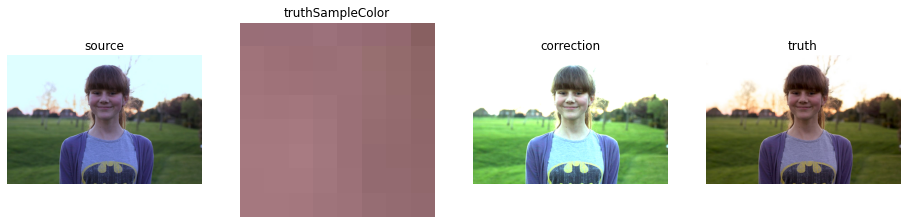

color difference:7.996


In [43]:
show_image_before_after(source,truthSkin, whitePatch(sourceSkin),truth,  "source","truthSampleColor", "correction","truth")
color_difference(whitePatch(sourceSkin),truth)

In [44]:
# improved white patch(Max RGB)
def whitePatch_I(sourceSample,targetSample):
            
            kR = 255/max(np.max(sourceSample [:,:,0]), np.max(targetSample [:,:,0]))
            kG = 255/max(np.max(sourceSample [:,:,1]), np.max(targetSample [:,:,1]))
            kB = 255/max(np.max(sourceSample [:,:,2]), np.max(targetSample [:,:,2]))
            outR = clip_mx((kR*source[:,:,0]),255).astype('uint8')
            outG = clip_mx((kG*source[:,:,1]),255).astype('uint8')
            outB = clip_mx((kB*source[:,:,2]),255).astype('uint8')
            OUT = np.dstack((outR, outG, outB))
            return OUT
    

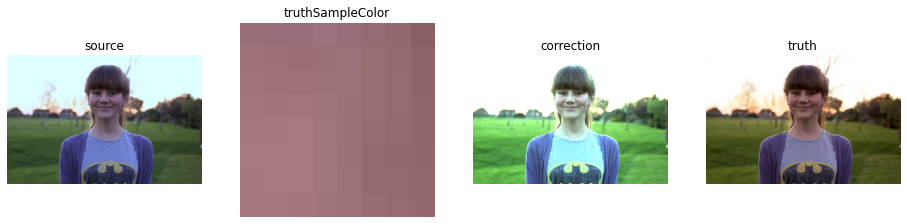

color difference:8.04


In [45]:
show_image_before_after(source,truthSkin, whitePatch_I(sourceSkin,truthSkin),truth,  "source","truthSampleColor", "correction","truth")
color_difference(whitePatch_I(sourceSkin,truthSkin),truth)

In [71]:
#white patch with selected color
%matplotlib inline

def set_focus(new_focus):
    global skinColor
    skinColor = new_focus
    selectSkinColor()
    
    correctionImage = whitePatch(sourceSkin,selectSkinColor())
    
    
    show_image_before_after(source,selectSkinColor(), correctionImage,truth,  "source", "selectColor","correction","truth")
    color_difference(correctionImage, truth)
_ = interact(set_focus, new_focus = widgets.IntSlider(min = 1, max = len(skinSelect), step = 1, value = skinColor))

interactive(children=(IntSlider(value=6, description='new_focus', max=7, min=1), Output()), _dom_classes=('wid…

In [47]:
# color correct then white patch

In [48]:
c_w = whitePatch(colorCorrect(sourceSkin,truthSkin))

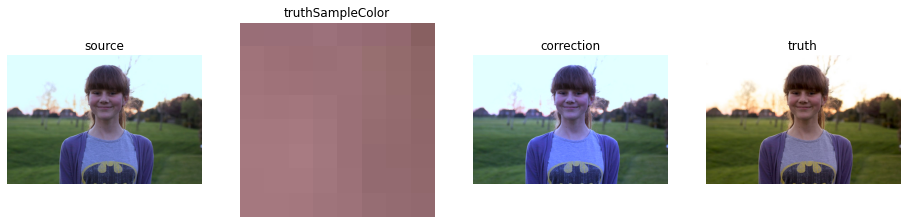

color difference:9.15


In [49]:
show_image_before_after(source,truthSkin,c_w,truth,  "source", "truthSampleColor", "correction","truth")
color_difference(c_w,truth)

In [72]:
#colour correct then white patch with selected color
%matplotlib inline

def set_focus(new_focus):
    global skinColor
    skinColor = new_focus
    selectSkinColor()
    
    correctionImage = whitePatch(colorCorrect(sourceSkin,selectSkinColor()))
    
    
    show_image_before_after(source,selectSkinColor(), correctionImage,truth,  "source", "selectColor","correction","truth")
    color_difference(correctionImage, truth)
_ = interact(set_focus, new_focus = widgets.IntSlider(min = 1, max = len(skinSelect), step = 1, value = skinColor))

interactive(children=(IntSlider(value=6, description='new_focus', max=7, min=1), Output()), _dom_classes=('wid…

In [50]:
#color correct (L*ab) then white patch

In [51]:
cl_w = whitePatch (colorCorrect_lab(sourceSkin,truthSkin))

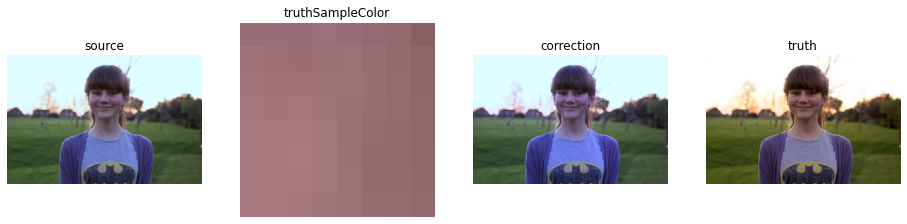

color difference:8.2


In [52]:
show_image_before_after(source,truthSkin,cl_w,truth,  "source", "truthSampleColor", "correction","truth")
color_difference(cl_w,truth)

In [53]:
# color correct then  improved white patch

In [54]:
c_iw = whitePatch_I(colorCorrect(sourceSkin,truthSkin), truthSkin)

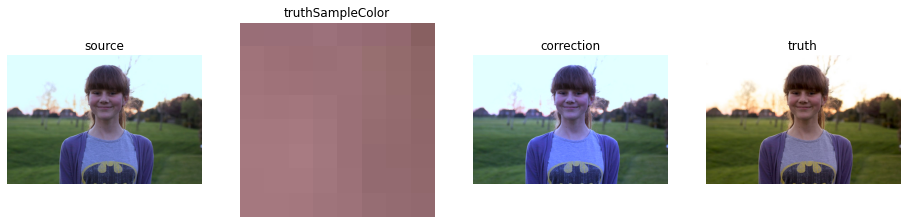

color difference:9.15


In [55]:
show_image_before_after(source,truthSkin,c_iw,truth,  "source", "truthSampleColor", "correction","truth")
color_difference(c_iw,truth)

In [56]:
#color correct (L*ab color space) then improved white patch

In [57]:
cl_iw = whitePatch_I(colorCorrect_lab(sourceSkin,truthSkin), truthSkin)

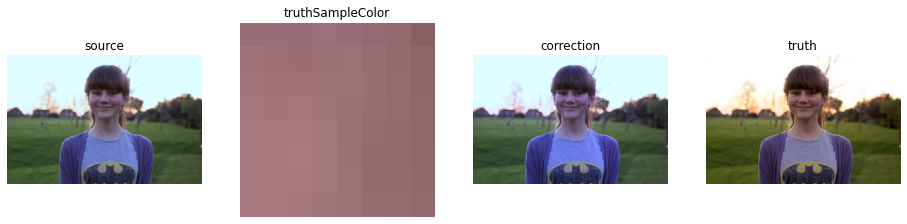

color difference:8.2


In [58]:
show_image_before_after(source,truthSkin,cl_iw,truth,  "source", "truthSampleColor", "correction","truth")
color_difference(cl_iw,truth)

In [59]:
# white patch then color correct

In [60]:
w_c = colorCorrect(whitePatch(sourceSkin),truthSkin)

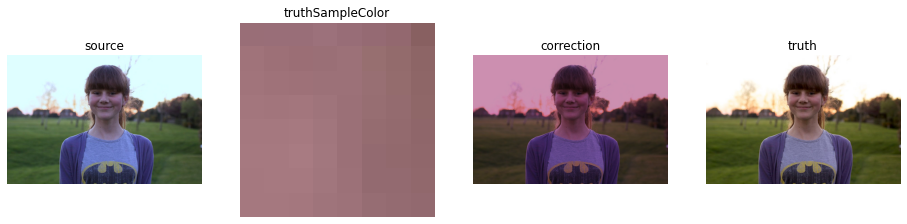

color difference:10.86


In [61]:
show_image_before_after(source,truthSkin,w_c,truth,  "source", "truthSampleColor", "correction","truth")
color_difference(w_c,truth)

In [74]:
#white patch then colour correct with selected color
%matplotlib inline

def set_focus(new_focus):
    global skinColor
    skinColor = new_focus
    selectSkinColor()
    
    correctionImage = colorCorrect(whitePatch(sourceSkin),selectSkinColor())
    
    
    show_image_before_after(source,selectSkinColor(), correctionImage,truth,  "source", "selectColor","correction","truth")
    color_difference(correctionImage, truth)
_ = interact(set_focus, new_focus = widgets.IntSlider(min = 1, max = len(skinSelect), step = 1, value = skinColor))

interactive(children=(IntSlider(value=7, description='new_focus', max=7, min=1), Output()), _dom_classes=('wid…

In [62]:
# white patch then color correct(L*ab)

In [63]:
w_cl = colorCorrect_lab(whitePatch(sourceSkin),truthSkin)

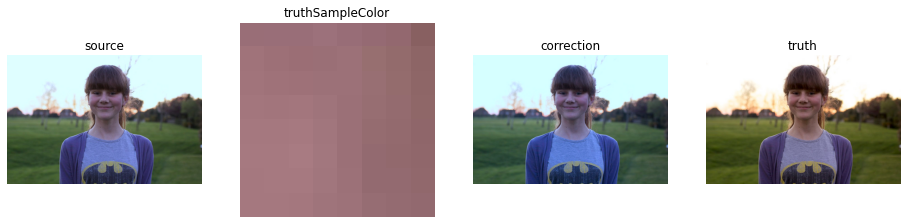

color difference:10.86


In [64]:
show_image_before_after(source,truthSkin,w_cl,truth,  "source", "truthSampleColor", "correction","truth")
color_difference(w_c
                 ,truth)

In [65]:
# improved white patch then color correct

In [66]:
iw_c = colorCorrect(whitePatch_I(sourceSkin,truthSkin),truthSkin)

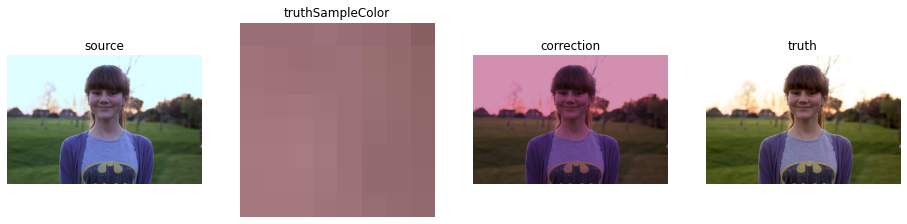

color difference:11.7


In [67]:
show_image_before_after(source,truthSkin,iw_c,truth,  "source", "truthSampleColor", "correction","truth")
color_difference(iw_c,truth)

In [68]:
# improved white patch then color correct(L*ab)

In [69]:
iw_cl = colorCorrect_lab(whitePatch_I(sourceSkin,truthSkin),truthSkin)

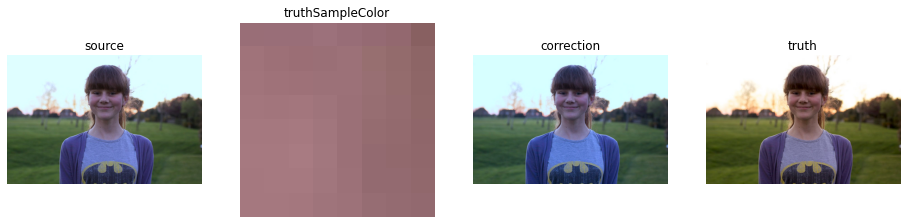

color difference:9.97


In [70]:
show_image_before_after(source,truthSkin,iw_cl,truth,  "source", "truthSampleColor", "correction","truth")
color_difference(iw_cl,truth)